In [1]:
"""
https://gist.github.com/alexsavio/9ecdc1279c9a7d697ed3

Some python code for
Markov Chain Monte Carlo and Gibs sampling
by Bruce Walsh
"""


import numpy as np
import numpy.linalg as npla


def gaussian(x, sigma, sampled=None):
    """

    """
    if sampled is None:
        L = npla.cholesky(sigma)
        z = np.random.randn(x.shape[0], 1)
        return np.dot(L, z+x)
    else:
        return np.exp(-0.5*np.dot( (x-sampled).T, np.dot(npla.inv(sigma), (x-sampled))))[0,0]


def gaussian_1d(x, sigma, sampled=None):
    """
    1d Gaussian
    """
    if sampled is None:
        return sigma*np.random.randn(1)[0]
    else:
        return np.exp(-0.5( (x-sampled)**2)/sigma**2)


def chi_sq(x, sampled = None, n = 0):
    """
    chi squared function. Adapted for
    usage in metropolis-hastings.
    """
    if sampled is None:
        return np.random.chisquare(n)
    else:
        return np.power(sampled,0.5*n - 1)*np.exp(-0.5*sampled)


def inv_chi_sq(theta, n, a):
    """
    scaled inverse chi squared function.
    """
    return np.power(theta, -0.5*n)*np.exp(-a/(2*theta))


def metropolis(f, proposal, old):
    """
    basic metropolis algorithm, according to the original,
    (1953 paper), needs symmetric proposal distribution.
    """
    new = proposal(old)
    alpha = np.min([f(new)/f(old), 1])
    u = np.random.uniform()
    # _cnt_ indicates if new sample is used or not.
    cnt = 0
    if (u < alpha):
        old = new
        cnt = 1
    return old, cnt


def met_hast(f, proposal, old):
    """
    metropolis_hastings algorithm.
    """
    new = proposal(old)
    alpha = np.min([(f(new)*proposal(new, sampled = old))/(f(old) * proposal(old, sampled = new)), 1])
    u = np.random.uniform()
    cnt = 0
    if (u < alpha):
        old = new
        cnt = 1
    return old, cnt

def run_chain(chainer, f, proposal, start, n, take=1):
    """
    _chainer_ is one of Metropolis, MH, Gibbs ...
    _f_ is the unnormalized density function to sample
    _proposal_ is the proposal distirbution
    _start_ is the initial start of the Markov Chain
    _n_ length of the chain
    _take_ thinning
    """
    count = 0
    samples = [start]
    for i in range(n):
        start, c = chainer(f, proposal, start)
        count = count + c
        if i%take is 0:
            samples.append(start)
    return samples, count

def uni_prop(x, frm, to, sampled=None):
    """
    a uniform proposal generator --
    is symmetric!
    """
    return np.random.uniform(frm, to)

In [16]:
import numpy as np

In [24]:
# how to use:
from functools import partial
import pylab
# from mcmc *
# MCMC and Gibbs Sampling, by Walsh, 2004, p.8
# proposal dist. is uniform (symmetric) -> metropolis
f = partial(inv_chi_sq, n = 5, a = 4)
prop = partial(uni_prop, frm=0, to = 100)
smpls = run_chain(metropolis, f, prop, 1, 5000)

In [25]:
x = np.linspace(-10,10,1000)

/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in power


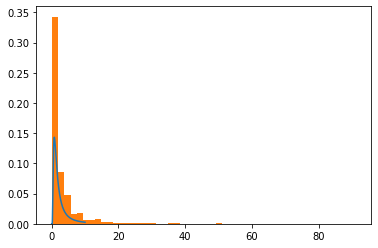

In [26]:
pylab.figure()
pylab.plot(x, f(x))
pylab.hist(smpls[0], bins=50, density=True);

In [30]:
# MCMC and Gibbs Sampling, Walsh, p. 9
f = partial(inv_chi_sq, n = 5, a = 4)
prop = partial(chi_sq, n=1)
smpls = run_chain(metropolis, f, prop, 1, 5000)

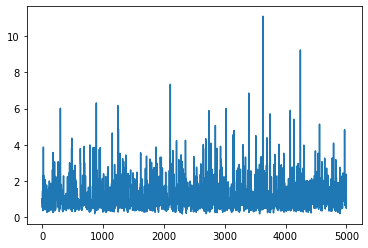

In [31]:
pylab.plot(smpls[0])


In [32]:
pylab.figure()
pylab.plot(x, f(x))
pylab.hist(smpls[0], bins=50, density=True);

/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in power


# another

In [ ]:
#https://twiecki.io/blog/2015/11/10/mcmc-sampling/

In [36]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from scipy.stats import norm

# sns.set_style('white')
# sns.set_context('talk')

np.random.seed(123)

In [37]:
data = np.random.randn(20)

In [40]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
#     sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.hist(data, bins=100, density=True);
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

In [43]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
# sns.despine()

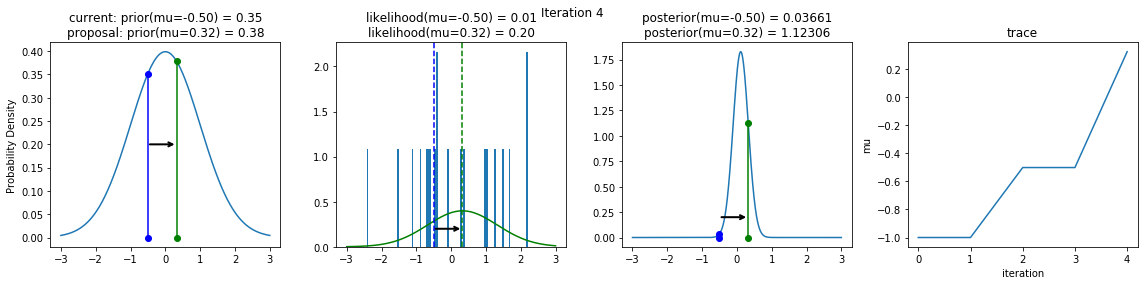

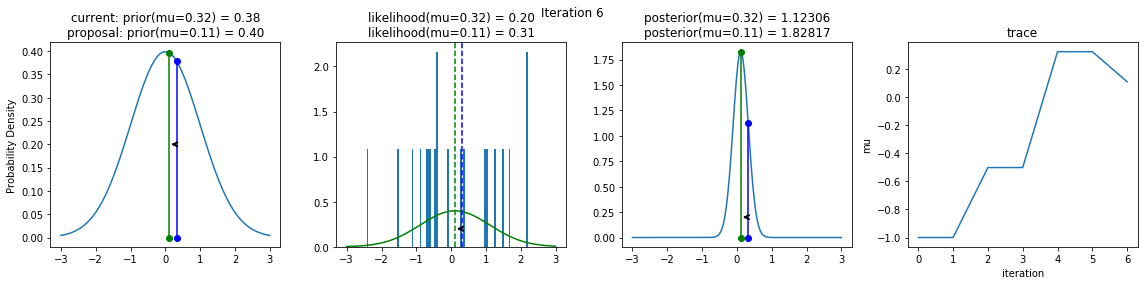

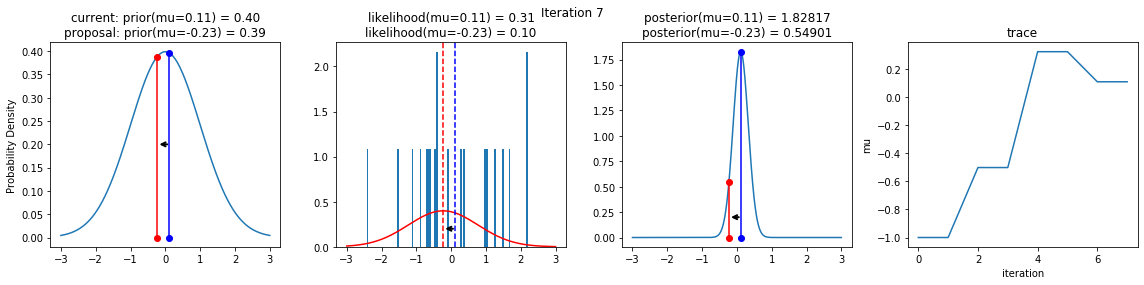

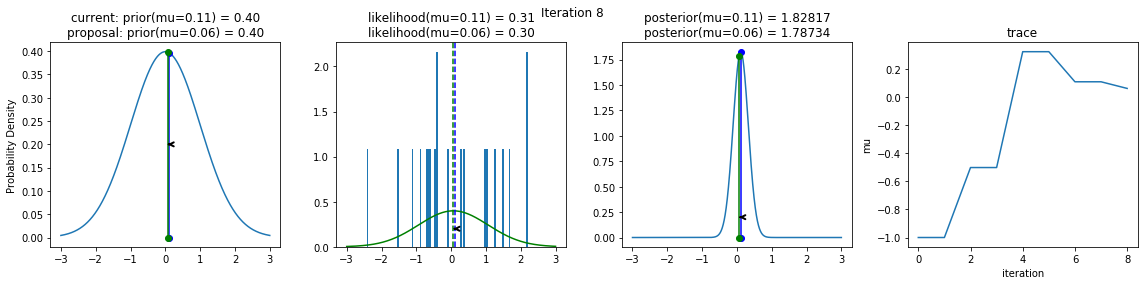

In [44]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);